# Research Questions Exploration - RQ1: Pre-training Effectiveness

This notebook provides interactive exploration and visualization of the RQ1 analysis results.

**Research Question 1:** Does multi-task, cross-domain pre-training improve downstream performance compared to from-scratch training?

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(exist_ok=True)

## 1. Load Analysis Results

In [2]:
# Load all RQ1 results
improvement_df = pd.read_csv(RESULTS_DIR / 'rq1_improvement_analysis.csv')
statistical_df = pd.read_csv(RESULTS_DIR / 'rq1_statistical_tests.csv')
best_schemes_df = pd.read_csv(RESULTS_DIR / 'rq1_best_schemes.csv')

# Load summary tables
scheme_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_scheme_summary.csv', index_col=0)
significance_summary = pd.read_csv(RESULTS_DIR / 'rq1_summary_significance_summary.csv', index_col=0)
domain_best = pd.read_csv(RESULTS_DIR / 'rq1_summary_domain_best_schemes.csv', index_col=0)

print(f'Loaded {len(improvement_df)} improvement results')
print(f'Loaded {len(statistical_df)} statistical test results')
print('\nScheme Summary:')
print(scheme_summary)

Loaded 96 improvement results
Loaded 96 statistical test results

Scheme Summary:
        mean_improvement  std_improvement  min_improvement  max_improvement  \
scheme                                                                        
b2                 -0.39             6.15            -9.12            11.32   
s3                 -2.58             6.14           -10.11             9.43   
s1                 -2.67            16.89           -23.60            35.85   
s2                 -2.81             7.87           -14.07            15.76   
b4                 -4.04             4.68           -13.48             0.00   
b3                 -4.53            11.21           -26.97            17.05   
s5                 -5.85             7.95           -25.86             7.55   
s4                 -5.89             4.87           -15.81             2.06   

        n_combinations  
scheme                  
b2                  12  
s3                  12  
s1                  12  
s2

## 2. Overall Performance Summary

In [3]:
# Key statistics
mean_improvement = improvement_df['improvement_percent'].mean()
positive_improvements = (improvement_df['improvement_percent'] > 0).sum()
total_combinations = len(improvement_df)

print('=' * 60)
print('OVERALL SUMMARY')
print('=' * 60)
print(f'Mean improvement across all schemes: {mean_improvement:.2f}%')
print(f'Positive improvements: {positive_improvements}/{total_combinations} ({positive_improvements/total_combinations*100:.1f}%)')
print(f'\nBest performing scheme: {scheme_summary.index[0]} (mean: {scheme_summary.iloc[0]["mean_improvement"]:.2f}%)')
print(f'Worst performing scheme: {scheme_summary.index[-1]} (mean: {scheme_summary.iloc[-1]["mean_improvement"]:.2f}%)')

# Statistical significance
total_significant = significance_summary['n_significant'].sum()
total_tests = significance_summary['total_tests'].sum()
print(f'\nStatistically significant improvements: {total_significant}/{total_tests} ({total_significant/total_tests*100:.1f}%)')

OVERALL SUMMARY
Mean improvement across all schemes: -3.60%
Positive improvements: 22/96 (22.9%)

Best performing scheme: b2 (mean: -0.39%)
Worst performing scheme: s4 (mean: -5.89%)

Statistically significant improvements: 0/96 (0.0%)


## 3. Visualization 1: Box Plots of Improvement by Scheme

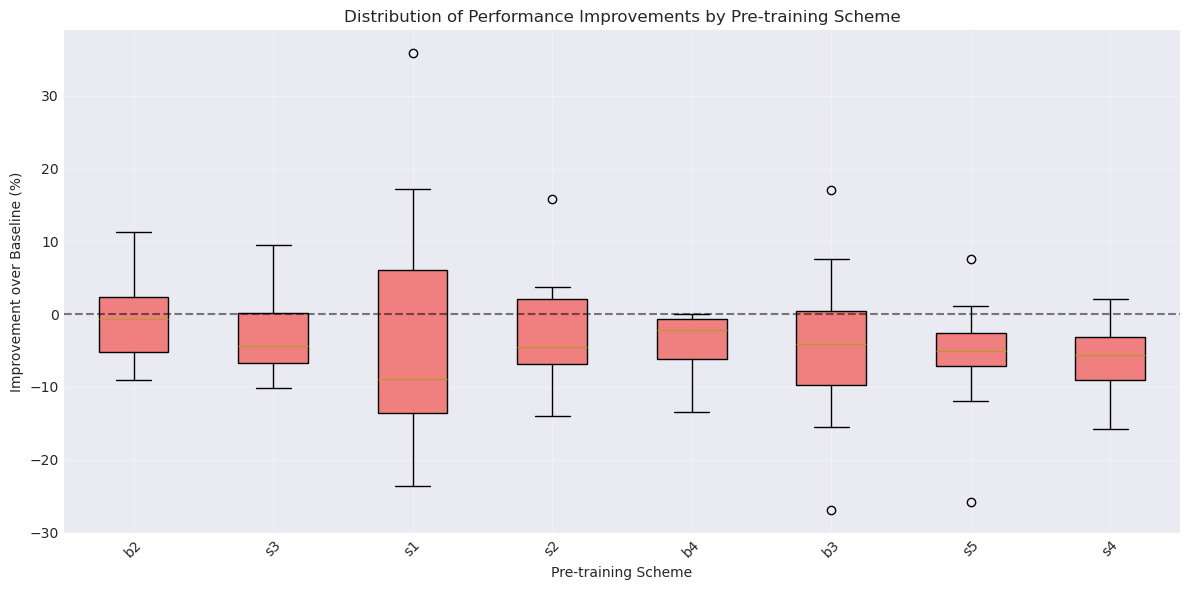

In [4]:
# Create box plot showing improvement distribution for each scheme
plt.figure(figsize=(12, 6))

# Order schemes by mean improvement
scheme_order = scheme_summary.sort_values('mean_improvement', ascending=False).index.tolist()

# Create box plot
data_for_plot = [improvement_df[improvement_df['scheme'] == scheme]['improvement_percent'].values 
                 for scheme in scheme_order]

bp = plt.boxplot(data_for_plot, labels=scheme_order, patch_artist=True)

# Color boxes based on positive/negative mean
for i, (patch, scheme) in enumerate(zip(bp['boxes'], scheme_order)):
    mean_val = scheme_summary.loc[scheme, 'mean_improvement']
    if mean_val > 0:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')

# Add zero line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.xlabel('Pre-training Scheme')
plt.ylabel('Improvement over Baseline (%)')
plt.title('Distribution of Performance Improvements by Pre-training Scheme')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_effectiveness_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Visualization 2: Improvement Heatmap (Domain × Scheme)

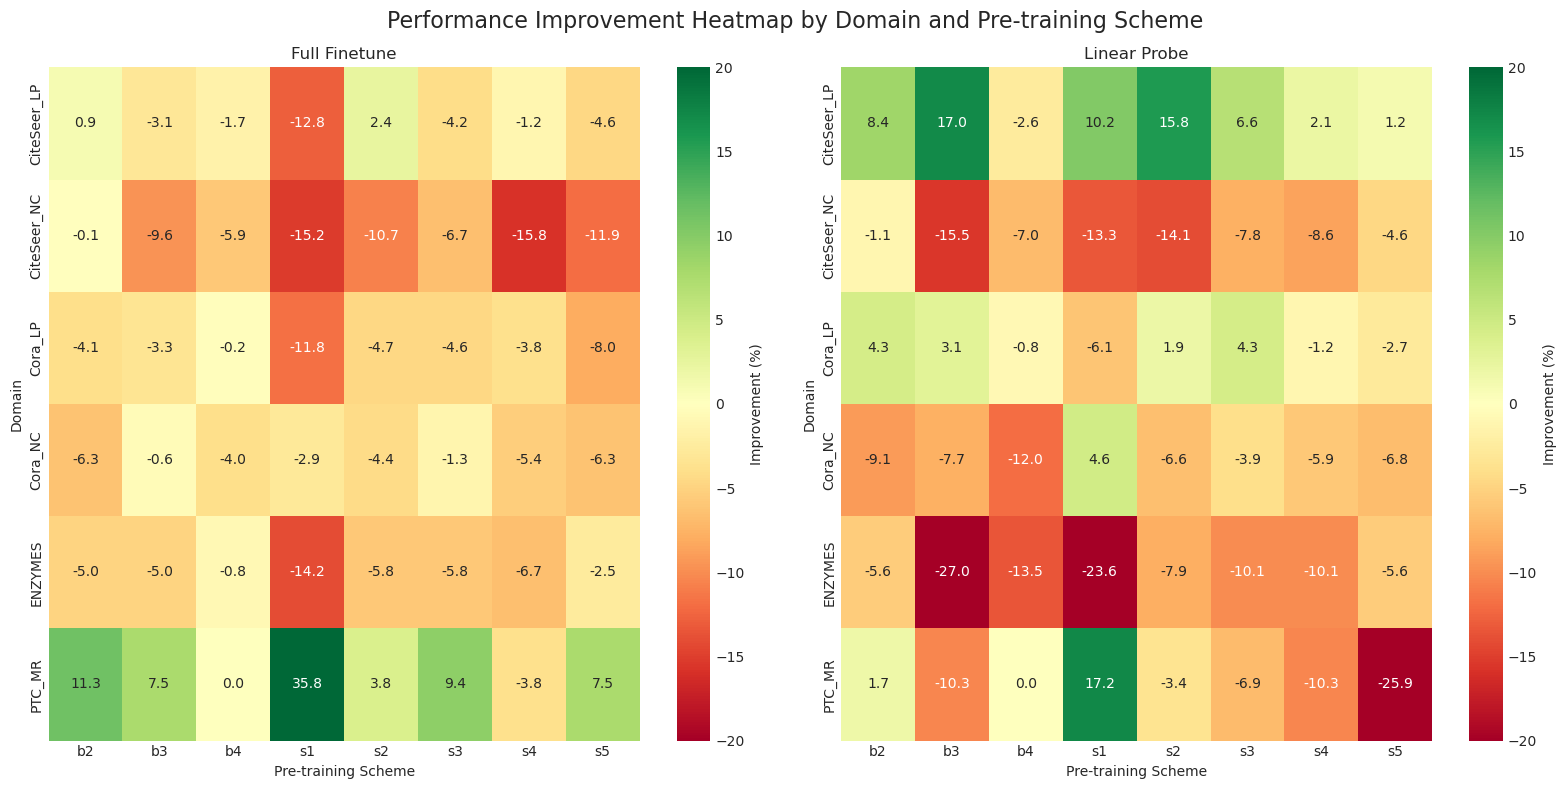

In [5]:
# Create heatmap showing improvement for each domain-scheme-strategy combination
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

strategies = improvement_df['strategy'].unique()

for idx, strategy in enumerate(strategies):
    # Filter data for this strategy
    strategy_data = improvement_df[improvement_df['strategy'] == strategy]
    
    # Create pivot table
    pivot_data = strategy_data.pivot_table(
        values='improvement_percent',
        index='domain',
        columns='scheme',
        aggfunc='mean'
    )
    
    # Plot heatmap
    ax = ax1 if idx == 0 else ax2
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', 
                center=0, vmin=-20, vmax=20, ax=ax, cbar_kws={'label': 'Improvement (%)'})
    ax.set_title(f'{strategy.replace("_", " ").title()}')
    ax.set_xlabel('Pre-training Scheme')
    ax.set_ylabel('Domain')

plt.suptitle('Performance Improvement Heatmap by Domain and Pre-training Scheme', fontsize=16)
plt.tight_layout()

# Save figure
plt.savefig(FIGURES_DIR / 'rq1_improvement_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()